<a href="https://colab.research.google.com/github/AARABAabdallah/RNAclassification/blob/master/Simple_LSTM_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

X, y = pd.read_csv(file.csv)

X_train, y_train, X_test, y_test, X_val, y_val = train_test_split(X,y)

X_train[0] = 'AAGAU...C'

X_train = oneHot_encode(X_train):
  
  'A' --> [1, 0, 0, 0]

  'C' --> [0, 1, 0, 0]

  'G' --> [0, 0, 1, 0]

  'U' --> [0, 0, 0, 1]


==> X_train[0] = [ [1, 0, 0, 0], [1, 0, 0, 0], [0, 0, 1, 0], [1, 0, 0, 0], [0, 0, 0, 1], ..., [0, 1, 0, 0]]

![Texte alternatif…](https://scontent.fymy1-1.fna.fbcdn.net/v/t1.15752-9/87964565_190099955594112_1480016893791174656_n.jpg?_nc_cat=104&_nc_sid=b96e70&_nc_ohc=x_lIXJ-yf9QAX_gGQjI&_nc_ht=scontent.fymy1-1.fna&oh=fa92218979c80294963037739b004bb1&oe=5EBC0581)




In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
from tqdm import tnrange
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import pickle

In [0]:
data = pd.read_csv('drive/My Drive/Colab Workspace/RNA_classification/DataSet/All_RNA_Families_IdSeqTotal_IdFamily_Seq.csv')
#Split data
X = np.array(data.sequence)
y = np.array(data.id_family)
family_labels = np.unique(np.array(y))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)
#Données de validations !
X_val1, X_val, y_val1, y_val = train_test_split(X_test, y_test, test_size=0.17)
#len(X_val)

In [0]:
X_train[0]

'CCUCUGGAGCGUUAUAUCAAACGUGAGUAGUCUGUUCUUCGGGACGGCAAAAGCGGACGCAGUGAAUGAGGAA'

In [0]:
 #Turning data into one hot coding
 
 def oneHot_encode(data):
  if isinstance(data,str) : # input is a string
    input_list = np.array(list(data))
    output = []
    for i in range(len(input_list)):
      if input_list[i] == 'A':
        output.append(np.array([1, 0, 0, 0]))
      elif input_list[i] == 'C':
        output.append(np.array([0, 1, 0, 0]))
      elif input_list[i] == 'G':
        output.append(np.array([0, 0, 1, 0]))
      elif input_list[i] == 'U':
        output.append(np.array([0, 0, 0, 1]))
      
    return output
  else: # input is an array of strings
    return np.array([ np.array(oneHot_encode(data[i])) for i in tnrange(int(data.shape[0]))])
 

In [0]:
X_train = oneHot_encode(X_train)
X_test = oneHot_encode(X_test)
X_val = oneHot_encode(X_val)

In [0]:
print(len(np.unique(y_train)))
print(len(np.unique(y_val)))

3016
1128


In [0]:
# OneHot Encoding labels: Just for now !!!
def one_hot_encode_labels(labels):
  output = []
  for i in tnrange(len(labels)):
    output_i = np.zeros(len(family_labels), dtype=int)
    output_i[labels[i]] = 1
    output.append(output_i)
  return np.array(output)

In [0]:
y_train = one_hot_encode_labels(y_train)
y_test = one_hot_encode_labels(y_test)
y_val = one_hot_encode_labels(y_val)

In [0]:
y_train[0].shape

(3016,)

# Model Training

In [0]:
# Model Creation
from keras.models import Sequential
from keras.layers import LSTM, Input, Dense, Activation, Embedding

model = Sequential()

model.add(LSTM(32, return_sequences=False, input_shape=(None, 4)))
model.add(Dense(3016,name='out_layer', activation='softmax'))
model.summary(90)

Model: "sequential_2"
__________________________________________________________________________________________
Layer (type)                            Output Shape                        Param #       
lstm_2 (LSTM)                           (None, 32)                          4736          
__________________________________________________________________________________________
out_layer (Dense)                       (None, 3016)                        99528         
Total params: 104,264
Trainable params: 104,264
Non-trainable params: 0
__________________________________________________________________________________________


In [0]:
def compute_accuracy(data, labels):
  acc = 0
  for i in range(len(data)):
    if np.argmax(model.predict(data[i].reshape(1, len(data[i]), 4))) == np.argmax(labels[i]):
      acc += 1
  return (acc/len(data))*100

def compute_loss(data, labels):
  loss = 0
  for i in range(len(data)):
    x = data[i].reshape(1, len(data[i]), 4)
    y = labels[i].reshape(1,len(labels[i]))
    loss += model.evaluate(x, y, verbose=0)
  return loss/len(data)


In [0]:
X_train_init = X_train
y_train_init = y_train
data_lentgh = len(X_train_init)
# train_generator is the training algorithm used by the keras model
def train_generator():
    i = 0
    while True:
        if i == data_lentgh: #End of one epoch
          i = 0
        j = data_lentgh - 1 - i
        x_tr = (X_train_init[j]).reshape(1, len(X_train_init[j]), 4)
        y_tr = y_train_init[j].reshape(1,len(y_train_init[j]))
        yield x_tr, y_tr
        i += 1
        if i % 100 == 0:
          model.save_weights("drive/My Drive/Colab Workspace/RNA_classification/models/LSTM_OneHot_without_padding_rectified.h5")

In [0]:
#Train epochs is a function in which we se the number of epochs we want to train the model on and a boolean parameter which says whether we have already trained the model so we can continue on what we have done before
history_file_name = 'drive/My Drive/Colab Workspace/RNA_classification/models/trainHistoryDict_without_padding_rectified'
model_file_name = "drive/My Drive/Colab Workspace/RNA_classification/models/LSTM_OneHot_without_padding_rectified.h5"
def train_epochs(n_epochs=1, already_trained=True):
  
  for i in range(n_epochs):
    
    if already_trained:
      # !!!!!!! Load old model with its history if the model has been trained before !!!!!!! 
      previous_history = pickle.load(open(history_file_name, "rb"))
      model.load_weights(model_file_name)

    
    # model training with train_generator ==> without batch optimization
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    history = model.fit(train_generator(), steps_per_epoch=len(X_train_init), epochs=1, verbose=1)

    #Compute train acc, val loss, val acc
    history.history['acc'] = [compute_accuracy(X_train_init, y_train_init)]
    history.history['val_acc'] = [compute_accuracy(X_val, y_val)]
    history.history['val_loss'] = [compute_loss(X_val, y_val)]
    
    if already_trained:
      #concatenate history if its been trained before !!!!!!!!!!
      history.history['acc'] = np.append(previous_history['acc'], history.history['acc'])
      history.history['val_acc'] = np.append(previous_history['val_acc'], history.history['val_acc'])
      history.history['loss'] = np.append(previous_history['loss'], history.history['loss'])
      history.history['val_loss'] = np.append(previous_history['val_loss'], history.history['val_loss'])
      
    model.save_weights(model_file_name)
    with open(history_file_name, 'wb') as file_pi:
          pickle.dump(history.history, file_pi)
    print("epoch: ", i+1)
    already_trained = True
  return history


In [0]:
def plot_history(history):
  # Plot training & validation accuracy values
  plt.plot(history['acc'])
  plt.plot(history['val_acc'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(history['loss'])
  plt.plot(history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

In [0]:
history = train_epochs(n_epochs=1,already_trained=False)

Epoch 1/1
54039/54039 [==============================] - 4824s 89ms/step - loss: 6.0575
epoch:  1


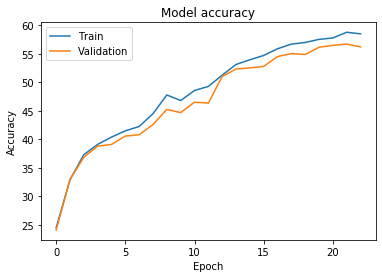

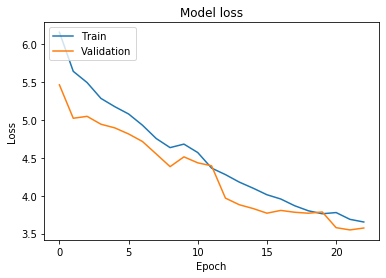

number of epochs:  23



{'acc': array([24.49897296, 32.92807047, 37.32304447, 39.12174541, 40.40045153,
        41.49780714, 42.26021947, 44.50674513, 47.78585836, 46.80138419,
        48.57787894, 49.27737375, 51.26297674, 53.13384778, 53.9554766 ,
        54.71603842, 55.88926516, 56.69979089, 56.98847129, 57.53437332,
        57.77864135, 58.7834712 , 58.50219286]),
 'loss': array([6.15367822, 5.63859061, 5.49066052, 5.28195552, 5.17297539,
        5.07654303, 4.9288987 , 4.75269515, 4.63331694, 4.6794053 ,
        4.56812064, 4.36303979, 4.27765375, 4.17877661, 4.09870674,
        4.01222926, 3.95610471, 3.86758558, 3.80038866, 3.76170773,
        3.77737014, 3.68801956, 3.65298522]),
 'val_acc': array([24.1266732 , 32.97420829, 36.85928828, 38.81815214, 39.11198172,
        40.58112961, 40.80966373, 42.60528893, 45.24975514, 44.69474372,
        46.52301665, 46.359778  , 51.02840353, 52.33431277, 52.53019915,
        52.791381  , 54.52171074, 55.04407444, 54.88083578, 56.15409729,
        56.4805746 , 56

In [0]:
#history_file_name = 'drive/My Drive/Colab Workspace/RNA_classification/models/trainHistoryDict_without_padding_rectified'
history_file_name_not_rectified = 'drive/My Drive/Colab Workspace/RNA_classification/models/trainHistoryDict_without_padding'
previous_history = pickle.load(open(history_file_name_not_rectified, "rb"))
plot_history(previous_history)
print("number of epochs: ", len(previous_history['loss']))
print()
previous_history

In [0]:
#Test accuracy
accuracy = compute_accuracy(X_test, y_test)
print("the model's accuracy is: ", accuracy, "%")


the model's accuracy is:  54.2275023594071 %
